In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

### Prepare csv for als

In [1]:
from helpers_als import prepare_csv_for_als
# DON'T FORGET TO REMOVE HEADER Id,Prediction
prepare_csv_for_als("data/try_old.csv")

### Load training file data_train.csv

In [2]:
from pyspark.sql import Row 
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .appName("ALSExample")\
        .getOrCreate()

lines = spark.read.text("data/data_train_processed.csv").rdd # "data/data_train_woHeader.csv" "data/try_woHeader.csv")
parts = lines.map(lambda row: row.value.split(","))
ratingsRDD = parts.map(lambda p: Row(movieId=int(p[0]), userId=int(p[1]), 
                                     rating=float(p[2])))
ratings = spark.createDataFrame(ratingsRDD)

### ALS without cross-validation - Plots

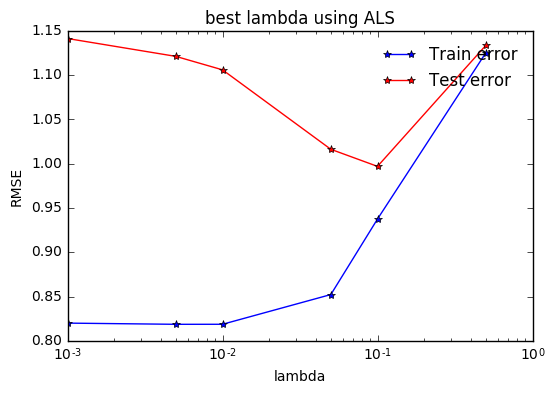

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.recommendation import ALS
from plots import plot_train_test_lambda, plot_train_test_K
from pyspark.ml.evaluation import RegressionEvaluator


#features_K = np.array([20, 25, 30, 35, 40, 45, 50])
lambda_ = np.array([0.5, 0.1, 0.05, 0.01, 0.005, 0.001])
(training, test) = ratings.randomSplit([0.8, 0.2])

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")
rmse_tr = []
rmse_te = []
for i,el in enumerate(lambda_):
    als = ALS(rank=20, maxIter=4, regParam=el, userCol="userId", itemCol="movieId", ratingCol="rating")  
    model = als.fit(training)
    
    predictions_tr = model.transform(training)
    rmse_tr_tmp = evaluator.evaluate(predictions_tr)
    rmse_tr.append(rmse_tr_tmp)
    
    predictions_te = model.transform(test)
    rmse_te_tmp = evaluator.evaluate(predictions_te)
    rmse_te.append(rmse_te_tmp)

#plot_train_test_K(rmse_tr, rmse_te, features_K)
plot_train_test_lambda(rmse_tr, rmse_te, lambda_)

### ALS with cross-validation - Plots

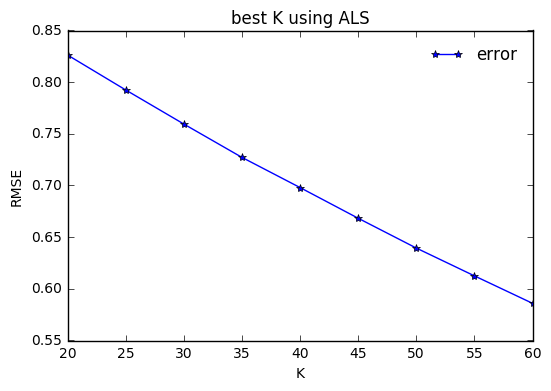

In [3]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from plots import plot_train_test_K_CV, plot_train_test_lambda_CV
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")
features_K = np.array([20, 25, 30, 35, 40, 45, 50, 55, 60])
#lambda_ = np.array([0.5, 0.1, 0.05, 0.01, 0.005, 0.001])
#iter_ = np.array([5, 10, 15, 20])
   
rmse_all = []
for i,el in enumerate(features_K):
    als_cv = ALS(rank=el, maxIter=10, regParam =0.01, userCol="userId", itemCol="movieId", ratingCol="rating")
    paramGrid = ParamGridBuilder().build()
    crossval = CrossValidator(
            estimator=als_cv,
            estimatorParamMaps=paramGrid,
            evaluator=evaluator,
            numFolds=4)
                       
    model = crossval.fit(ratings)
    
    predictions_cv_all = model.transform(ratings)
    rmse_all_tmp = evaluator.evaluate(predictions_cv_all)
    rmse_all.append(rmse_all_tmp)
    

plot_train_test_K_CV(rmse_all, features_K)
#plot_train_test_lambda_CV(rmse_all, lambda_)